In [2]:
import numpy as np
import os
import pandas as pd
import re
import requests
import kagglehub
import sys
import matplotlib.pyplot as plt
import pickle
from dataclasses import dataclass

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Stock Price Prediction Using Machine Learning Models

by Andon Gorchov (@thunderman913)

## Abstract

This project aims to build machine learning models, which are good at predicting stock prices, based on stock and financial data. Various models will be explored, including Support Vector Regression (SVR), K-Nearest Neighbors (KNN), Random Forest Regressors (RFR) and Linear Regression The analysis uses historical stock data, which includes factors such as the value of a stock, trade volume and economic indicators. In order to train and evaluate this model, the dataset is pre-processed and analyzed under appropriate conditions, so that the model can be run. Apart from the data, hyperparameter tuning is performed using GridSearchCV to find the optimal parameters for each algorithm. The performance of the models is evaluated using Mean Squared Error (MSE) to compare their accuracy in predicting stock closing prices. The findings provide insights into the effectiveness of different machine learning techniques for stock price forecasting, highlighting the strengths and limitations of each approach in dealing with financial market data.

## 1. Problem Definition

Trying to predict the stock market price is a century old task, that no one has yet perfected. The big corporations and hedge funds put their best effort to outsmart the normal traders, but still they sometimes fail. There has not been a perfect tool for predicting the price and if one comes out at any point, it will for sure disrupt the market. The project's main goal is to create machine learning models, that are sufficient in predicting the price of a stock. Two different datasets will be used to achieve this goal - stock price data and earnings data. Everything will be preprocessed, so that the models can be run on it and hopefully predict close to the actual data. 4 different models will be explored and experimented with, so we can see, which one performs best in our circumstances. The hyperparameters will be tuned as much as possible, but since the dataset has 27 different features and nearly 7 million rows - the task to perfect the model will be difficult. In no means, I am expecting the models to predict accurately to the actual price, but I do expected, that some models work much better than others.

## 2. Data analysis and tidying

We will need some stock datasets and the perfect one for this task is this one:

https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

It contains daily stock price informations for more than 7000 tickers. Also it has earnings data for the different stock. Some are quarterly, others are yearly, but we will figure out how to use them. First lets define some methods, that will be used for reading the data.

In order not to download the dataset locally, we can read it from the remote using those paths.

Pickles will be used for most of the data processed/machine learning models, because those are slow operations and it is better for us, not to perform them every time.

In [3]:
path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

earnings_path = f"{path}\\stocks_latest\\earnings_latest.csv"
stock_prices_path = f"{path}\\stocks_latest\\stock_prices_latest.csv"

earnings_data_path = './pickles/earnings_data_processed.pkl'
stock_data_path = './pickles/stock_data_processed.pkl'

In [4]:
# Calculate the peak price over a rolling window and days since the peak price
def get_peak_price_and_days_ago(df):
    df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

# Adds features like prices and volumes for specific days ago for each stock (ticker)
# and calculates the peak price and days since the peak price
def process_ticker_data(df):
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close'].shift(days)
        df[f'volume_{days}_days_ago'] = df.groupby('ticker')['volume'].shift(days)

    df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)

    return df

In [5]:
# Adding earnings data to stock_data_tidy based on the nearest previous date
def add_earnings_data(stock_data, earnings):
    merged_df = pd.merge_asof(
        stock_data.sort_values(by='date'),
        earnings.sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='backward'
    )
    
    # Ensure non-trading days are adjusted properly
    merged_df = merged_df.sort_values(by=['ticker', 'date'])

    merged_df = pd.merge_asof(
        merged_df.sort_values(by='date'),
        earnings[['ticker', 'earnings_date']].sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='forward',
        suffixes=('', '_next'),
        allow_exact_matches=False
    )
    
    # Remove NA earnings dates
    merged_df = merged_df.drop(merged_df[(merged_df.earnings_date.isna()) | (merged_df.earnings_date_next.isna())].index)
    merged_df['days_till_report'] = (merged_df['earnings_date_next'] - merged_df['date']).dt.days
    merged_df['days_since_report'] = (merged_df['date'] - merged_df['earnings_date']).dt.days

    return merged_df

In [6]:
# Read and tidy the earnings data dataset
def getEarningsData():

    if os.path.exists(earnings_data_path):
        return pd.read_pickle(earnings_data_path)

    earnings_data = pd.read_csv(earnings_path)

    earnings_data_tidy = earnings_data
    earnings_data_tidy.date = pd.to_datetime(earnings_data_tidy.date)

    earnings_data_tidy = earnings_data_tidy.rename(columns={'symbol': 'ticker'})

    earnings_data_tidy = earnings_data_tidy.drop(earnings_data_tidy[(earnings_data_tidy.eps.isna()) | (earnings_data_tidy.eps_est.isna())].index)
    earnings_data_tidy = earnings_data_tidy.drop(columns=['qtr'])

    earnings_data_tidy = earnings_data_tidy.rename(columns={'date': 'earnings_date'})

    earnings_data_tidy['release_time'] = earnings_data_tidy.groupby('ticker')['release_time'].ffill().bfill()

    earnings_data_tidy.to_pickle(earnings_data_path)

    return earnings_data_tidy

In [7]:
# Read and tidy the stock data dataset
def getTidiedStockData():
    # Check if the file exists
    if os.path.exists(stock_data_path):
        return pd.read_pickle(stock_data_path)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    earnings_data_tidy = getEarningsData()

    stock_data_tidy = stock_data_tidy[(stock_data_tidy['date'] > (earnings_data_tidy['earnings_date'].min() - pd.Timedelta(days=100)))
                                    | (stock_data_tidy['date'] < earnings_data_tidy['earnings_date'].max() + pd.Timedelta(days=5))]

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    stock_data_tidy = stock_data_tidy[stock_data_tidy.price_90_days_ago.isna() == False]
    
    stock_data_tidy = add_earnings_data(stock_data_tidy, earnings_data_tidy)

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])
    
    stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy

In [8]:
stock_data_tidy = getTidiedStockData()

After everything writte above, we can just call the above method and get all of the data needed for the machine learning.

In [9]:
stock_data_tidy

,ticker,date,open,high,low,close,close_adjusted,volume,price_1_days_ago,volume_1_days_ago,...,peak_price,peak_days_ago,earnings_date,eps_est,eps,release_time,earnings_date_next,days_till_report,days_since_report,ticker_encoded
11137135,C,2012-07-16,27.4500,27.5300,26.6200,26.8100,26.0433,59427600,26.6500,48422100.0,...,38.08,81,2012-07-16,0.88,0.95,pre,2012-10-15,91,0,718
11138878,CSX,2012-07-17,22.7300,22.8600,22.2800,22.7900,20.1997,7041400,22.5900,4914000.0,...,22.79,0,2012-07-17,0.47,0.49,post,2012-10-16,91,0,1105
11138900,FIS,2012-07-17,34.3200,34.5200,34.1300,34.2300,31.2043,1177000,34.3000,1234200.0,...,34.80,9,2012-07-17,0.60,0.66,post,2012-11-05,111,0,1605
11139425,WYNN,2012-07-17,97.4500,98.2700,95.5801,97.3600,96.6684,2317100,96.4400,2089100.0,...,135.04,55,2012-07-17,1.48,1.38,post,2012-10-24,99,0,4548
11140712,C,2012-07-17,27.1300,27.4100,26.6100,27.3800,26.5970,39561100,26.8100,59427600.0,...,38.08,82,2012-07-16,0.88,0.95,pre,2012-10-15,90,1,718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23691461,ADXS,2021-06-10,0.5285,0.5477,0.5100,0.5244,0.5244,5190814,0.5233,10176718.0,...,1.41,79,2020-09-10,-0.15,-0.09,post,2021-06-14,4,273,81
23692035,RFIL,2021-06-10,8.0000,8.0000,7.9100,7.9600,7.9600,26264,7.9300,14128.0,...,7.98,5,2021-03-11,0.03,-0.03,pre,2021-06-14,4,91,3506
23693010,ADXS,2021-06-11,0.5173,0.5379,0.5060,0.5156,0.5156,4467153,0.5244,5190814.0,...,1.41,80,2020-09-10,-0.15,-0.09,post,2021-06-14,3,274,81
23693122,RFIL,2021-06-11,7.9700,8.0200,7.8000,7.8000,7.8000,78435,7.9600,26264.0,...,7.98,6,2021-03-11,0.03,-0.03,pre,2021-06-14,3,92,3506


We can see the features it has - ticker, prices and volumes for each day, latest earnings, days since and till next report and also the peak price.

The earnings have been added to the actual data, but with a different frequence and this is the reason why, the columns days_till_report and days_since_report are introduces. Every single row has the latest earnings. For example if the earnings are 5 days ago, we fill those. If the earnings happened today we fill them. If they happened 70 days ago, we fill them with the latest ones. Having the days to and since the next report will help our model understand this.

In [10]:
stock_data_tidy[['ticker','date', 'earnings_date', 'earnings_date_next', 'days_till_report', 'days_since_report']]

,ticker,date,earnings_date,earnings_date_next,days_till_report,days_since_report
11137135,C,2012-07-16,2012-07-16,2012-10-15,91,0
11138878,CSX,2012-07-17,2012-07-17,2012-10-16,91,0
11138900,FIS,2012-07-17,2012-07-17,2012-11-05,111,0
11139425,WYNN,2012-07-17,2012-07-17,2012-10-24,99,0
11140712,C,2012-07-17,2012-07-16,2012-10-15,90,1
...,...,...,...,...,...,...
23691461,ADXS,2021-06-10,2020-09-10,2021-06-14,4,273
23692035,RFIL,2021-06-10,2021-03-11,2021-06-14,4,91
23693010,ADXS,2021-06-11,2020-09-10,2021-06-14,3,274
23693122,RFIL,2021-06-11,2021-03-11,2021-06-14,3,92


We remove data with more than 120 days on both next and previous report, since that is useless data for our case. We want the model to be able to predict data, when it has enough information about it.

We also remove some columns, that are not used in the trainings:

open, high, low, close_adjusted and volume - those are features, that are about our current day, that we want to predict. For the previous days for the most part, we shouldn't care, what those are, since we are gonna have the close price.

In [11]:
stock_data_tidy = stock_data_tidy.drop(stock_data_tidy[(stock_data_tidy.days_till_report > 120) & (stock_data_tidy.days_since_report > 120)].index)
# Remove useless columns
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close_adjusted', 'volume'])

In [12]:
stock_data_tidy.shape[0]

6713717

In [13]:
stock_data_tidy.ticker.unique().shape[0]

4640

We can see, that we have 6.7 million rows of data with 4640 different stocks being tracked. That should be pretty much enough data for our task.

## 3. Model Training

Now that, the data is prepared and tidied, we can continue with the model training. Let's first define some variables and methods.

In [14]:
features = [
    'ticker_encoded', 'peak_price', 'peak_days_ago', 'price_1_days_ago', 'volume_1_days_ago',
    'price_2_days_ago', 'volume_2_days_ago', 'price_3_days_ago', 'volume_3_days_ago',
    'price_4_days_ago', 'volume_4_days_ago', 'price_5_days_ago', 'volume_5_days_ago',
    'price_10_days_ago', 'volume_10_days_ago', 'price_15_days_ago', 'volume_15_days_ago',
    'price_30_days_ago', 'volume_30_days_ago', 'price_60_days_ago', 'volume_60_days_ago',
    'price_90_days_ago', 'volume_90_days_ago', 'eps_est', 'eps', 'days_till_report', 'days_since_report'
]

target = 'close'

Those are all the features we will use througout the different models. Our target will obviously be the close price.

In [15]:
@dataclass
class PreparedData:
    X_train: any
    X_test: any
    y_train: any
    y_test: any
    scaler_X: any = None
    scaler_y: any = None

# Function to prepare the data for model training and evaluation
# This function scales features and target, and splits the dataset into training, testing, and final test sets
def prepare_data(data, features, target, scale_output, frac=0.05):
    stock_data_tidy_train = data.sample(frac=frac, random_state=42)
    
    X = stock_data_tidy_train[features]
    y = stock_data_tidy_train[target]

    scaler_X = StandardScaler()
    X = scaler_X.fit_transform(X)
    
    if scale_output:    
        scaler_y = StandardScaler()
        y = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()
    else:
        scaler_X, scaler_y = None, None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return PreparedData(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        scaler_X=scaler_X,
        scaler_y=scaler_y
    )

We will use the "prepare_data" function to prepare the data for the training. It does all the work - scales the data where necessary and splits it into train, test and final test sets. The final test set is kept completely separate from the training data, to provide an unbiased evaluation of the model's performance on new, unseen data. This is particularly important for stock data, where overfitting is a risk due to the complexity and volatility of financial markets.

Also let's initialize all the pickle paths we will use for the different models.

In [ ]:
forest_grid_search_path = './pickles/forest_grid_search.pkl'
svr_grid_search_path = './pickles/svr_grid_search.pkl'
knn_grid_search_path = './pickles/knn_grid_search.pkl'

svr_model_path = './pickles/svr_model.pkl'
knn_model_path = './pickles/knn_model.pkl'
forest_model_path = './pickles/forest_model.pkl'

forest_mse_plots_path = './pickles/forest_mse_plots.pkl'
checkpoint_file = "./pickles/random_forest_checkpoint.pkl"
chunk_index_file = "./pickles/random_forest_chunk_index.pkl"

### 3.1. Random Forest Regressor

Let's begin with the GridSearch, in order to get the best hyperparams.

We get 1% of the data, in order to do the calculations for it. It is around 67k rows of data, which should be pretty much enough for our case. Having more would be better, but the time it takes grows very much.

In [17]:
forest_grid_search_data = prepare_data(stock_data_tidy, features, target, False, 0.01)

In [18]:
def getGridSearch():
    if os.path.exists(forest_grid_search_path):
        return pd.read_pickle(forest_grid_search_path)

    param_grid = {
        'n_estimators': [1, 50, 100, 200, 300],
        'max_depth': [5, 10, 20, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    forest_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, n_jobs=-1)
    forest_grid_search.fit(forest_grid_search_data.X_train, forest_grid_search_data.y_train)

    best_params = forest_grid_search.best_params_
    print(f"Best Parameters: {best_params}")

    with open(forest_grid_search_path, 'wb') as model_file:
        pickle.dump(forest_grid_search, model_file)

    return forest_grid_search

In [19]:
forest_grid_search = getGridSearch()

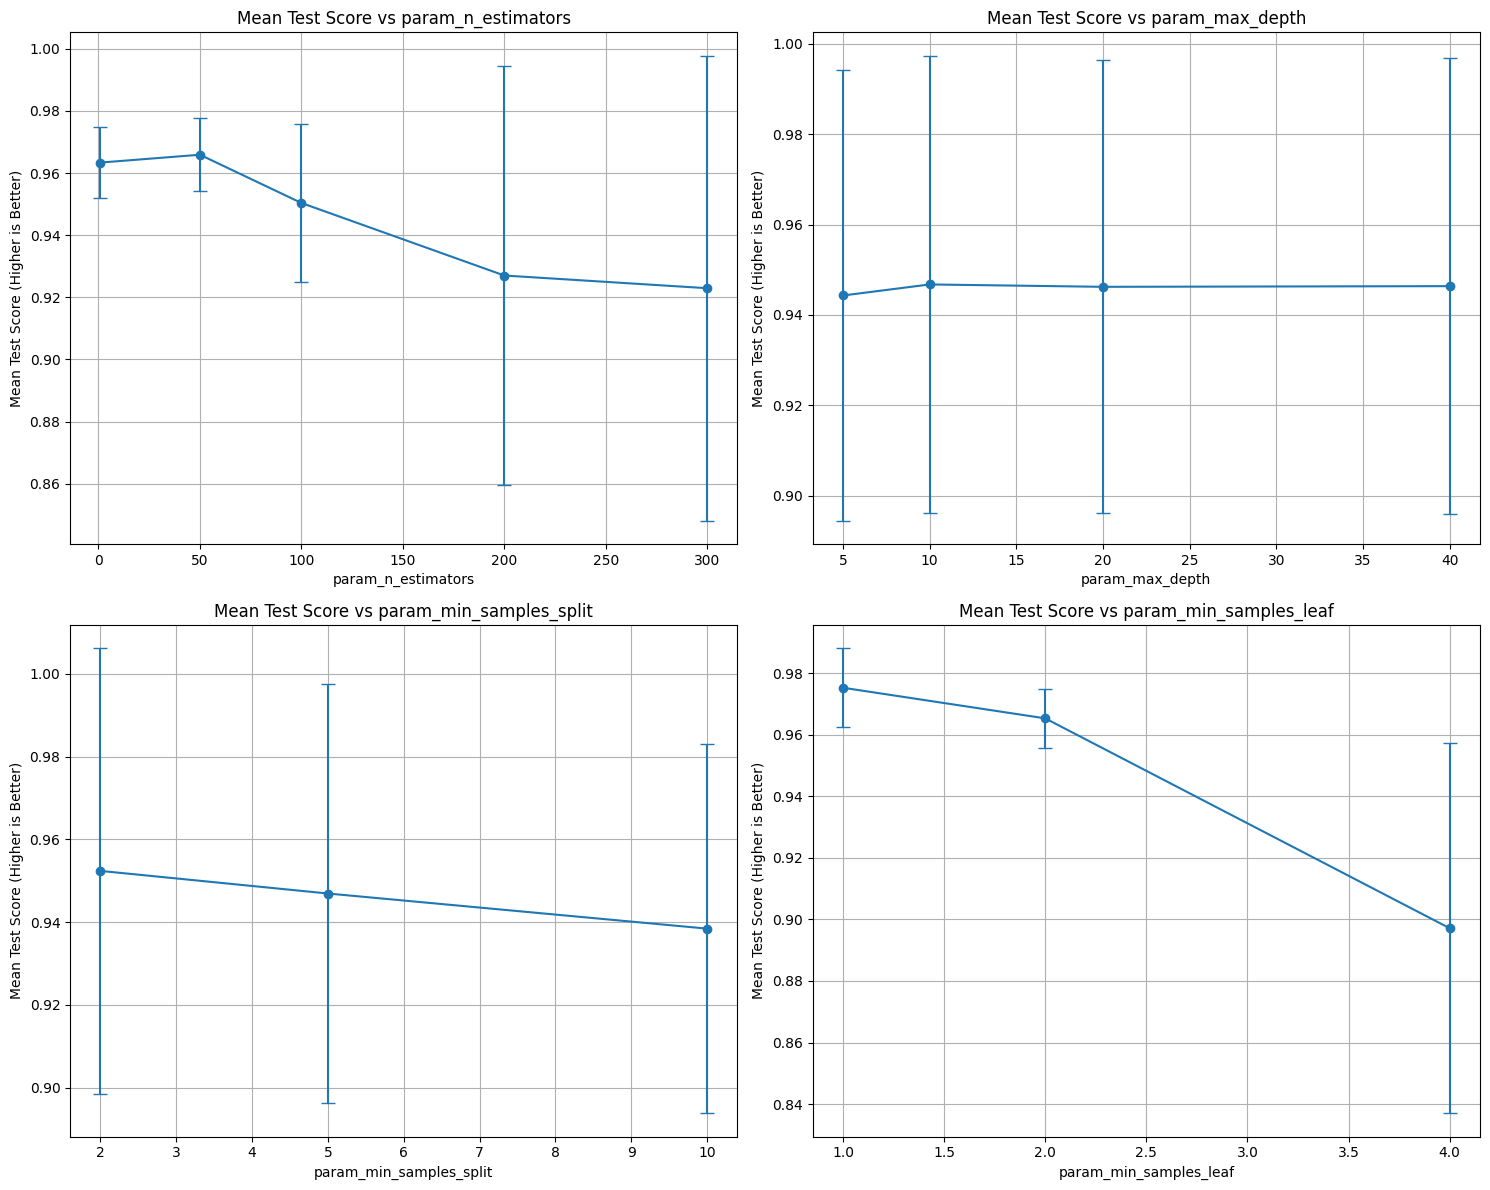

In [20]:
params = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf']
cv_results = pd.DataFrame(forest_grid_search.cv_results_)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

axs = axs.flatten()

for i, param in enumerate(params):
    mean_test_scores = cv_results.groupby(param)['mean_test_score'].mean()
    std_test_scores = cv_results.groupby(param)['mean_test_score'].std()
    
    # Plotting the mean test score with error bars representing the standard deviation
    axs[i].errorbar(mean_test_scores.index, mean_test_scores, yerr=std_test_scores, fmt='o-', capsize=5, capthick=1)
    axs[i].set_xlabel(param)
    axs[i].set_ylabel('Mean Test Score (Higher is Better)')
    axs[i].set_title(f'Mean Test Score vs {param}')
    axs[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [21]:
forest_grid_search.best_params_

{'max_depth': 40,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

Now that we have all the data visualized, we can choose our hyperparams correctly.

The ones from the GridSearch are:

{'max_depth': 40,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

Max depth specifies the maximum depth of each tree in the forest. Usually the deeper it is, the higher risk there is for overfitting. On the other side shallower trees might underfit. In our case, we can see, that the max depth doesn't change much the accuracy of our model. The grid search suggests, that we use 40, so we will keep to that, as we cannot see much of a difference.

Min sample leaf defines the minimum number of samples required in a leaf node. When the value is 1, the model might overfit, so we will monitor for overfitting and if we get results close to 100, then we should increase this value. We can see from the charts above, that 1 is by far the best value for our data, the accuracy of the rest is falling significantly.

Min sample splits is the number of samples to split a node. Generally low values tend to overfit the model, but 2 is a good value to start with and see, what the accuracy will be. 2 is also the default setting for the random forest regressor, so using it is usually the go to value and since we can obviously see from the charts, that it is much better than higher values, we will go with it and monitor the model for overfitting.

N estimators is the number of trees in the forest. More trees improve model stability and performance, but increase computation cost. We will begin with 50, since this is the suggestion from the grid search. Our way of fitting the model is by incrementally fitting the data, since the dataset is huge and fitting it all at once will be very slow and 50 is the go-to value for only 1% of the data. When incrementally fitting the model, we will add 10 estimators for each chunk of 10 000.

Now let's create the data, to which we will train our model. We want to use all the 6.7 mil rows, so we prepare the data that way.

In [34]:
forest_model_data = prepare_data(stock_data_tidy, features, target, False, 1)

Then we fit the data, using the best hyperparams we figured out. Again this is gonna be a slow process, so we use a pickle for it.

I tried fitting the model locally and it took 2 hours and got nowhere, so I managed to fit it using google colab's processing units in under 1 hour.

We incrementally fit the model using the warm_start option. Our chunks are 10 000 each and we add 10 estimators per chunk, which should be good enough value for such added data.

At first we check, if we have already have a checkpoint or fitted the model itself. If we already have a pickle of the model, then we just load it and don't do the whole fitting part. Otherwise we load the checkpoint and continue from it.

In [ ]:
chunk_size = 10000
save_interval = 10

# Load or initialize model
if os.path.exists(forest_model_path):
    with open(forest_model_path, 'rb') as f:
        forest_model = pickle.load(f)
else:
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            forest_model = pickle.load(f)
        print("Loaded model from checkpoint.")
        with open(chunk_index_file, 'rb') as f:
            start_chunk = pickle.load(f)
        print(f"Loaded model from checkpoint. Resuming from chunk {start_chunk}.")
    else:
        forest_model = RandomForestRegressor(
            max_depth=40,
            min_samples_leaf=1,
            min_samples_split=2,
            n_estimators=50,
            warm_start=True,
            random_state=42)
        start_chunk = 0
        
    for i, chunk_start in enumerate(range(start_chunk * chunk_size, len(forest_model_data.X_train), chunk_size), start=start_chunk):
        print(f"Fitting {i} chunk, {len(forest_model_data.X_train) - (chunk_start + chunk_size)} rows left")
        X_chunk = forest_model_data.X_train[chunk_start:chunk_start + chunk_size]
        y_chunk = forest_model_data.y_train[chunk_start:chunk_start + chunk_size]

        if i > 0:
            forest_model.n_estimators += 10 
        forest_model.fit(X_chunk, y_chunk)

        if (i + 1) % save_interval == 0 or (chunk_start + chunk_size) >= len(forest_model_data.X_train):
            with open(checkpoint_file, 'wb') as f:
                pickle.dump(forest_model, f)
            with open(chunk_index_file, 'wb') as f:
                pickle.dump(i + 1, f)
            print(f"Saved model checkpoint at iteration {i + 1}")

    print("Training complete. Final model saved.")

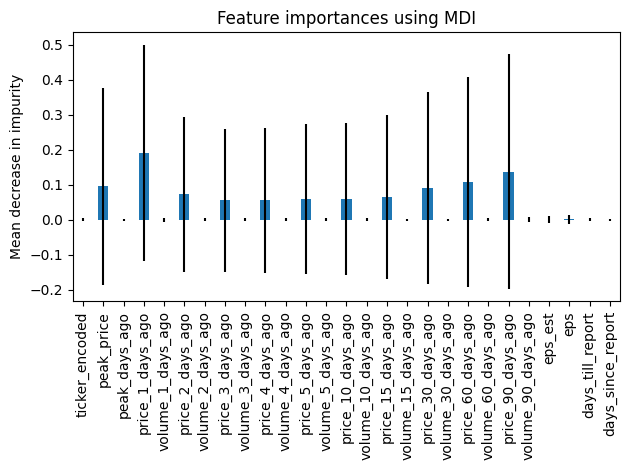

In [ ]:
std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)

importances = forest_model.feature_importances_
feature_names = [f"feature {i}" for i in features]
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

After completing the training, we can view the importance of the features. Some of them are highly biased, while others not so much. We can see, that the volume does not really matter in predicting the stock price. Also the financial data is a bit influencial, but more or less useless. The most important data is about the peak price and the prices beforehand.

In [ ]:
y_pred = forest_model.predict(forest_model_data.X_test)

mse = np.mean((forest_model_data.y_test - forest_model_data.y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

In [ ]:
forest_model.score(forest_model_data.X_test, forest_model_data.y_test)

0.8927607020913794

The model has an accuracy of ... and a MSE (Mean Squared Error) of .... TODO

## 3.2. Linear Regression

The second model we will look into is linear regression. Here we don't need any hyperparam tuning, so we just prepare the data for the model and perform the machine learning.

The fitting of this algorithm is very fast, takes just 5 seconds.

In [32]:
linear_regression_data = prepare_data(stock_data_tidy, features, target, False, 1)

Training Score: 0.9999282088343111
Mean Squared Error: 529.9234564341557


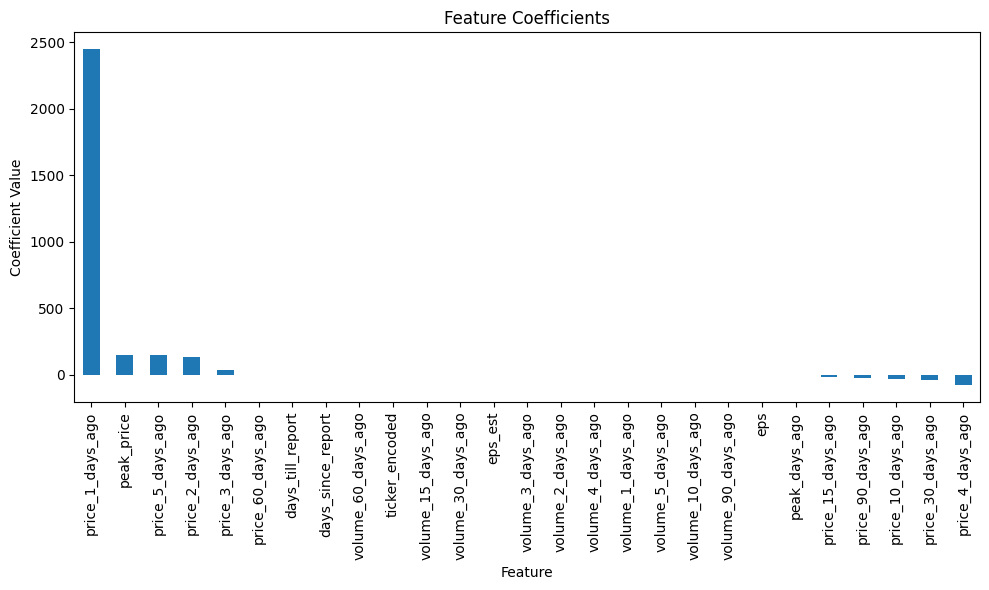

In [33]:
linear_model = LinearRegression()
linear_model.fit(linear_regression_data.X_train, linear_regression_data.y_train)

# Score the model on the training data
train_score = linear_model.score(linear_regression_data.X_train, linear_regression_data.y_train)
print(f"Training Score: {train_score}")

# Make predictions on the test set
y_pred = linear_model.predict(linear_regression_data.X_test)

# Calculate and print the mean squared error
mse = np.mean((linear_regression_data.y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

# Linear regression does not provide feature importances in the same way as RandomForest
# Instead, we can look at the coefficients
coefficients = pd.Series(linear_model.coef_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Feature Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [36]:
train_score = linear_model.score(linear_regression_data.X_test, linear_regression_data.y_test)
print(f"Training Score: {train_score}")

Training Score: 0.9999208876303298


In [167]:
# Test a certain row
linear_regression_data.X_final_test[1].__len__()
predicted_close = linear_model.predict(linear_regression_data.X_final_test[-3].reshape(1,-1))
predicted_close

predicted_close, linear_regression_data.y_final_test[19994519]


(array([218.06628373]), np.float64(220.09))

### 3.3. Support Vector Regression

In [37]:
svr_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.005)

In [38]:
def getSvrGridSearch():
    if os.path.exists(svr_grid_search_path):
        return pd.read_pickle(svr_grid_search_path)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5, 1],
        'kernel': ['linear', 'rbf', 'poly']
    }

    svr = SVR()
    svr_grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    svr_grid_search.fit(svr_grid_search_data.X_train, svr_grid_search_data.y_train)

    with open(svr_grid_search_path, 'wb') as model_file:
        pickle.dump(svr_grid_search, model_file)

    # Best parameters from GridSearchCV
    best_params_svr = svr_grid_search.best_params_
    print(f"Best Parameters for SVR: {best_params_svr}")

    return svr_grid_search

In [39]:
svr_grid_search = getSvrGridSearch()

In [40]:
print(svr_grid_search.best_params_)

{'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}


In [41]:
def evaluate_svr_param(param_name, param_values, mse_results_svr):
    mse_values = []
    for value in param_values:
        model_params = svr_grid_search.best_params_
        model_params[param_name] = value
        model = SVR(**model_params)
        model.fit(svr_grid_search_data.X_train, svr_grid_search_data.y_train)
        y_pred = model.predict(svr_grid_search_data.X_test)
        mse = mean_squared_error(svr_grid_search_data.y_test, y_pred)
        mse_values.append(mse)
        print(f"Mean Squared Error for {param_name}={value}: {mse}")
    
    mse_results_svr[param_name] = (param_values, mse_values)

# Get or create the SVR GridSearchCV results
if os.path.exists(svr_grid_search_path):
    svr_grid_search = pd.read_pickle(svr_grid_search_path)
else:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5, 1],
        'kernel': ['linear', 'rbf', 'poly']
    }

    svr = SVR()
    svr_grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    svr_grid_search.fit(svr_grid_search_data.X_train, svr_grid_search_data.y_train)

    with open(svr_grid_search_path, 'wb') as model_file:
        pickle.dump(svr_grid_search, model_file)

# Gather MSE results for SVR parameters
mse_results_svr = {}

C_values = [0.1, 1, 10, 100]
evaluate_svr_param('C', C_values, mse_results_svr)

epsilon_values = [0.01, 0.1, 0.5, 1]
evaluate_svr_param('epsilon', epsilon_values, mse_results_svr)

# Plot all MSE results for SVR in a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for ax, (param_name, (param_values, mse_values)) in zip(axs.flatten(), mse_results_svr.items()):
    ax.plot(param_values, mse_values, marker='o', linestyle='-', label=f'MSE vs {param_name}')
    ax.set_xlabel(f'Values of {param_name}')
    ax.set_ylabel('Mean Squared Error')
    ax.set_title(f'Mean Squared Error vs {param_name}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
# Train the best SVR model
best_svr_model = svr_grid_search.best_estimator_

Mean Squared Error for SVR: 203.2492067389844


In [181]:
svr_model_data = prepare_data(stock_data_tidy, features, target, False, 1)

In [ ]:
svr_model = SVR(C=0.1, epsilon=0.01, kernel='poly', random_state = 42)
svr_model.fit(svr_model_data.X_train, svr_model_data.y_train)

with open(forest_grid_search_path, 'wb') as model_file:
    pickle.dump(forest_grid_search, model_file)

In [ ]:
y_pred_svr_scaled = best_svr_model.predict(svr_grid_search_data.X_test)

# Inverse transform the predictions to convert back to actual prices
y_pred_svr = svr_grid_search_data.scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1)).ravel()

# Calculate and print the mean squared error for SVR
y_test_original = svr_grid_search_data.scaler_y.inverse_transform(svr_grid_search_data.y_test.reshape(-1, 1)).ravel()
mse_svr = mean_squared_error(y_test_original, y_pred_svr)
print(f"Mean Squared Error for SVR: {mse_svr}")

In [ ]:
svr_model.score(svr_grid_search_data.X_final_test, svr_grid_search_data.y_final_test)

NameError: name 'X_final_test' is not defined

### 3.4. K-Nearest Neighbors

In [16]:
knn_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.05)

NameError: name 'prepare_data' is not defined

In [14]:
def getKnnGridSearch():
    if os.path.exists(knn_grid_search_path):
        return pd.read_pickle(knn_grid_search_path)

    param_grid_knn = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
    }

    knn = KNeighborsRegressor()
    knn_grid_search = GridSearchCV(knn, param_grid_knn, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    knn_grid_search.fit(knn_grid_search_data.X_train, knn_grid_search_data.y_train)

    with open(knn_grid_search_path, 'wb') as model_file:
        pickle.dump(svr_grid_search, model_file)

    return svr_grid_search

In [19]:
knn_grid_search = getKnnGridSearch()

# Best parameters from GridSearchCV for KNN
best_params_knn = knn_grid_search.best_params_
print(f"Best Parameters for KNN: {best_params_knn}")

Best Parameters for KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [41]:
knn_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.1)

In [36]:
knn = KNeighborsRegressor(n_neighbors = 5, p = 1, weights = 'distance')
knn.fit(knn_grid_search_data.X_test, knn_grid_search_data.y_test)

KNeighborsRegressor(p=1, weights='distance')

In [42]:
# Train the best KNN model
best_knn_model = knn_grid_search.best_estimator_
y_pred_knn_scaled = best_knn_model.predict(knn_grid_search_data.X_test)

# Inverse transform the predictions to convert back to actual prices
y_pred_knn = knn_grid_search_data.scaler_y.inverse_transform(y_pred_knn_scaled.reshape(-1, 1)).ravel()

# Calculate and print the mean squared error for KNN
y_test_original = knn_grid_search_data.scaler_y.inverse_transform(knn_grid_search_data.y_test.reshape(-1, 1)).ravel()
mse_knn = mean_squared_error(y_test_original, y_pred_knn)
print(f"Mean Squared Error for KNN: {mse_knn}")

Mean Squared Error for KNN: 8370.654007299672


In [136]:
with open(knn_grid_search_path, 'wb') as model_file:
    pickle.dump(knn_grid_search, model_file)

In [ ]:
if os.path.exists(knn_grid_search_path):
    tst = pd.read_pickle(knn_grid_search_path)

In [ ]:
tst.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

In [17]:
knn_data = prepare_data(stock_data_tidy, features, target, True, 1)

In [18]:
knn = KNeighborsRegressor(n_neighbors=3, p=1, weights='distance')

# Fit the model on the training data
knn.fit(knn_data.X_train, knn_data.y_train)

KNeighborsRegressor(n_neighbors=3, p=1, weights='distance')

In [ ]:
y_pred = knn.predict(knn_data.X_test[0])

In [26]:
mse = mean_squared_error(knn_grid_search_data.y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0002022629573134599


## 4. Conclusion